In [1]:
!gdown --id 1qm0Ty5onZX3H1Our7TvaCFOCvNu3wvyw

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qm0Ty5onZX3H1Our7TvaCFOCvNu3wvyw
To: /content/captcha_images_v2.zip
100% 9.08M/9.08M [00:00<00:00, 49.4MB/s]


In [2]:
!unzip captcha_images_v2.zip

Archive:  captcha_images_v2.zip
   creating: captcha_images_v2/
 extracting: captcha_images_v2/ydd3g.png  
 extracting: captcha_images_v2/36nx4.png  
 extracting: captcha_images_v2/3bnyf.png  
 extracting: captcha_images_v2/8y6b3.png  
 extracting: captcha_images_v2/268g2.png  
 extracting: captcha_images_v2/mnef5.png  
 extracting: captcha_images_v2/5p8fm.png  
 extracting: captcha_images_v2/bxxfc.png  
 extracting: captcha_images_v2/8ypdn.png  
 extracting: captcha_images_v2/gpxng.png  
 extracting: captcha_images_v2/e4gd7.png  
 extracting: captcha_images_v2/pbpgc.png  
 extracting: captcha_images_v2/m4g8g.png  
  inflating: captcha_images_v2/c43b4.png  
 extracting: captcha_images_v2/gwnm6.png  
 extracting: captcha_images_v2/w4x2m.png  
 extracting: captcha_images_v2/npxb7.png  
 extracting: captcha_images_v2/445cc.png  
 extracting: captcha_images_v2/pg2pm.png  
 extracting: captcha_images_v2/wc2bd.png  
 extracting: captcha_images_v2/mc8w2.png  
 extracting: captcha_images_v2/67

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from torch.nn import functional as F

In [4]:
# Define the Dataset Class
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [f for f in os.listdir(directory) if f.endswith('.png') or f.endswith('.jpg')]
        self.labels = [f.split('_')[0] for f in self.images]  # Assuming label is the prefix of the filename
        self.unique_chars = set(''.join(self.labels))  # Extract all unique characters

        # Create a mapping from characters to indices
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.unique_chars)}
        self.char_to_idx['<blank>'] = 0  # CTC blank token
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        label = img_name.split('.')[0]  # Assuming label is the prefix of the filename

        # Encode the label
        encoded_label = [self.char_to_idx[char] for char in label]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(encoded_label, dtype=torch.long)

In [5]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((32, 100)),  # Resize images to fit model input
    transforms.ToTensor()
])

# Instantiate dataset to extract num_classes
train_dataset = ImageDataset(directory='/content/captcha_images_v2', transform=transform)
num_classes = len(train_dataset.unique_chars) + 1  # Add one for the CTC blank label

# Data loader with transformations
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
next(iter(train_loader))

[tensor([[[[0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           [0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           [0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           ...,
           [0.7647, 0.7686, 0.7725,  ..., 0.9922, 0.9961, 0.9961],
           [0.7647, 0.7686, 0.7725,  ..., 0.9922, 0.9961, 0.9961],
           [0.7647, 0.7686, 0.7725,  ..., 0.9922, 0.9961, 0.9961]]],
 
 
         [[[0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           [0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           [0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           ...,
           [0.7647, 0.7686, 0.7725,  ..., 0.9922, 0.9961, 0.9961],
           [0.7647, 0.7686, 0.7725,  ..., 0.9922, 0.9961, 0.9961],
           [0.7647, 0.7686, 0.7725,  ..., 0.9922, 0.9961, 0.9961]]],
 
 
         [[[0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           [0.7529, 0.7569, 0.7608,  ..., 0.9804, 0.9843, 0.9843],
           [0.7529

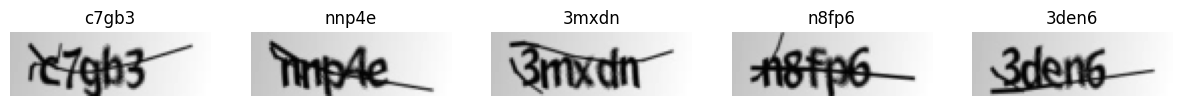

In [7]:
# Visualize a few training samples
def visualize_samples(dataset, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        label_str = ''.join([dataset.idx_to_char[c.item()] for c in label])
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(label_str)
        axs[i].axis('off')
    plt.show()

visualize_samples(train_dataset)

In [8]:
# Model Definition (CRNN)
class CRNN(nn.Module):
    def __init__(self, num_classes, input_height=32):
        super(CRNN, self).__init__()
        self.num_classes = num_classes

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        def _num_features(input_height):
            return (input_height // 4) * 128

        self.rnn = nn.LSTM(input_size=_num_features(input_height), hidden_size=256, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(512, num_classes)


    def forward(self, x):
        # Pass the input through the CNN layers
        x = self.conv(x)
        # Ensure the CNN output is correctly reshaped for the RNN layers
        x = x.permute(0, 3, 1, 2)  # Batch, Width (as seq), Channels, Height
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # Batch, Seq_length, Features
        # Pass the output through the RNN layers
        x, _ = self.rnn(x)
        # Apply the fully connected layer to each time step
        x = self.fc(x)  # No need to select last time step here as we're dealing with sequences
        return x


# Instantiate the model with the calculated num_classes
model = CRNN(num_classes=num_classes)

In [9]:
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(1024, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=21, bias=True)
)

In [10]:
# Define the loss and optimizer
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence

# Set the model to training mode
model.train()

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, labels in train_loader:
        # Move data to the appropriate device (GPU or CPU)
        images = images.to(device)

        # Flatten the labels and compute their lengths
        flat_labels = [label for label in labels]
        flat_labels = torch.cat(flat_labels).to(device)
        target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long).to(device)

        # Forward pass
        outputs = model(images)

        # CTC loss requires log probabilities
        outputs = outputs.log_softmax(2)

        # Compute input lengths
        input_lengths = torch.full(size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long).to(device)

        # Compute CTC loss
        loss = criterion(outputs.permute(1, 0, 2), flat_labels, input_lengths, target_lengths)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}')


Epoch [10/100], Loss: 2.7089070984811494
Epoch [20/100], Loss: 0.02658404280064684
Epoch [30/100], Loss: 0.0023855003351910095
Epoch [40/100], Loss: 0.0011043529692952607
Epoch [50/100], Loss: 0.0006273610042901992
Epoch [60/100], Loss: 0.00039762750296204376
Epoch [70/100], Loss: 0.0002674971006909442
Epoch [80/100], Loss: 0.00018834775652397764
Epoch [90/100], Loss: 0.0001373369437219067
Epoch [100/100], Loss: 0.00010295265096691296


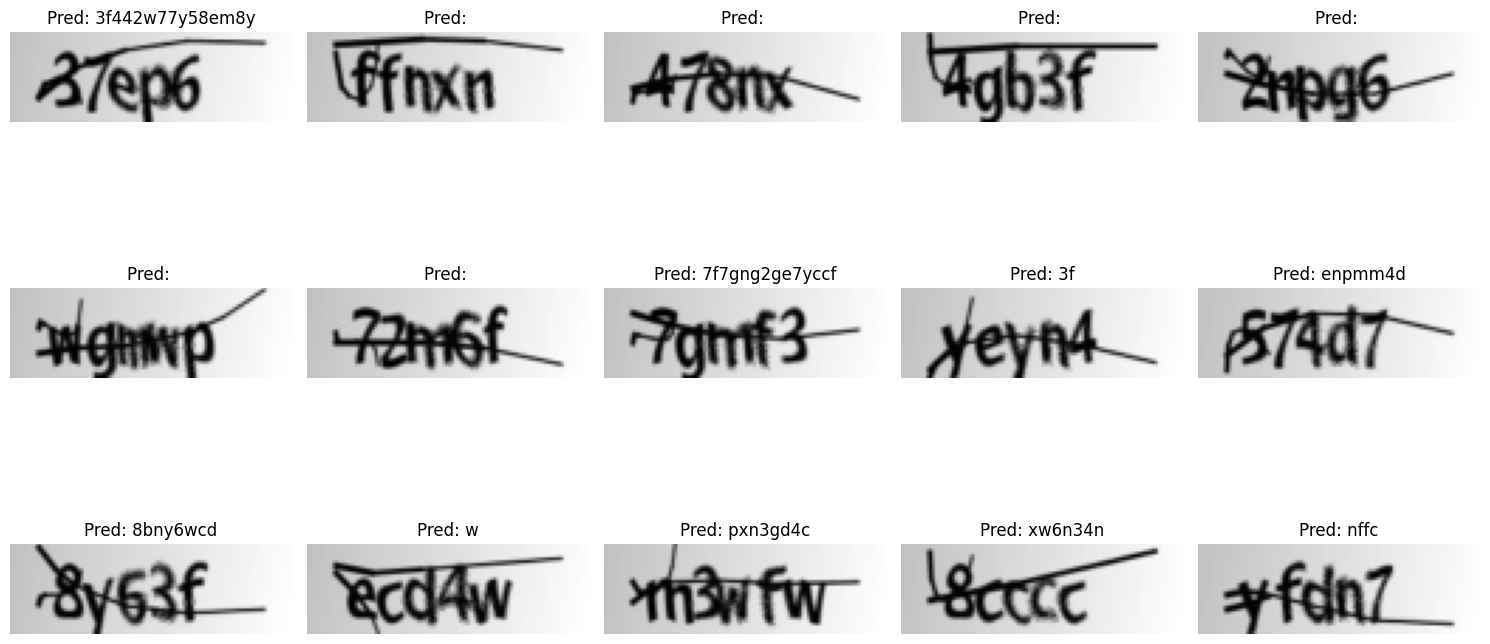

In [12]:
import matplotlib.pyplot as plt
import random

# Function to decode predictions
def decode_predictions(output, idx_to_char):
    # Find the index with the highest probability
    _, max_indices = torch.max(output, 2)
    max_indices = max_indices.permute(1, 0)  # Transpose to get (batch, seq_len)

    decoded_labels = []
    for indices in max_indices:
        label = ""
        for idx in indices:
            if idx.item() != 0:  # Ignore the CTC blank token
                label += idx_to_char[idx.item()]
        decoded_labels.append(label)

    return decoded_labels

# Set the model to evaluation mode
model.eval()

# Create a dictionary to map indices to characters
idx_to_char = {idx: char for char, idx in train_dataset.char_to_idx.items()}

# Randomly select 15 images from the training dataset
indices = random.sample(range(len(train_dataset)), 15)
selected_images = [train_dataset[i] for i in indices]

# Prepare images for prediction
images = torch.stack([img for img, _ in selected_images]).to(device)

# Get the true labels for comparison
true_labels = [label for _, label in selected_images]

# Forward pass
with torch.no_grad():
    outputs = model(images)
    outputs = outputs.log_softmax(2)

# Decode the predictions
predicted_labels = decode_predictions(outputs, idx_to_char)

# Plot the images with their predicted labels
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()

for ax, img, true_label, pred_label in zip(axs, images.cpu(), true_labels, predicted_labels):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Pred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()
